In [1]:
import datetime
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from src.dataset import OzeDataset, OzeEvaluationDataset, OzeNPZDataset
from src.model import BenchmarkLSTM

# Parameters

In [2]:
BATCH_SIZE = 4
NUM_WORKERS = 4
LR = 1e-2
EPOCHS = 5
HIDDEN_DIM = 100
K = 672

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda:0


# Train the benchmark

### Load the dataset

In [3]:
dataset = OzeDataset(dataset_x_path="datasets/x_train_LsAZgHU.csv", dataset_y_path="datasets/y_train_EFo1WyE.csv", labels_path="labels.json")

dataloader = DataLoader(dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=NUM_WORKERS)

m, M = dataloader.dataset.m, dataloader.dataset.M
# Normalization constants, we will need them in the prediction part

### Load the network

In [4]:
# Load benchmark network with Adam optimizer and MSE loss function
net = BenchmarkLSTM(hidden_dim=HIDDEN_DIM).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss()

### Train the network

[Epoch   5/5]: 100%|██████████| 7500/7500 [03:16<00:00, 38.13it/s, loss=0.00276]
model exported to model_2020_05_04__002718.pth with loss 0.002708


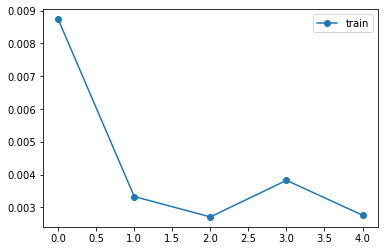

In [5]:
model_save_path = f'model_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth'
train_loss_best = np.inf

# Prepare loss history
hist_loss = np.zeros(EPOCHS)
for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(dataloader.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Comupte loss
            loss = loss_function(y.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])

        train_loss = running_loss/len(dataloader)
        pbar.set_postfix({'loss': train_loss})

        hist_loss[idx_epoch] = train_loss

        if train_loss < train_loss_best:
            train_loss_best = train_loss
            torch.save(net.state_dict(), model_save_path)

plt.plot(hist_loss, 'o-', label='train')
plt.legend()
print(f"model exported to {model_save_path} with loss {train_loss_best:5f}")

### Plot the results for a training example

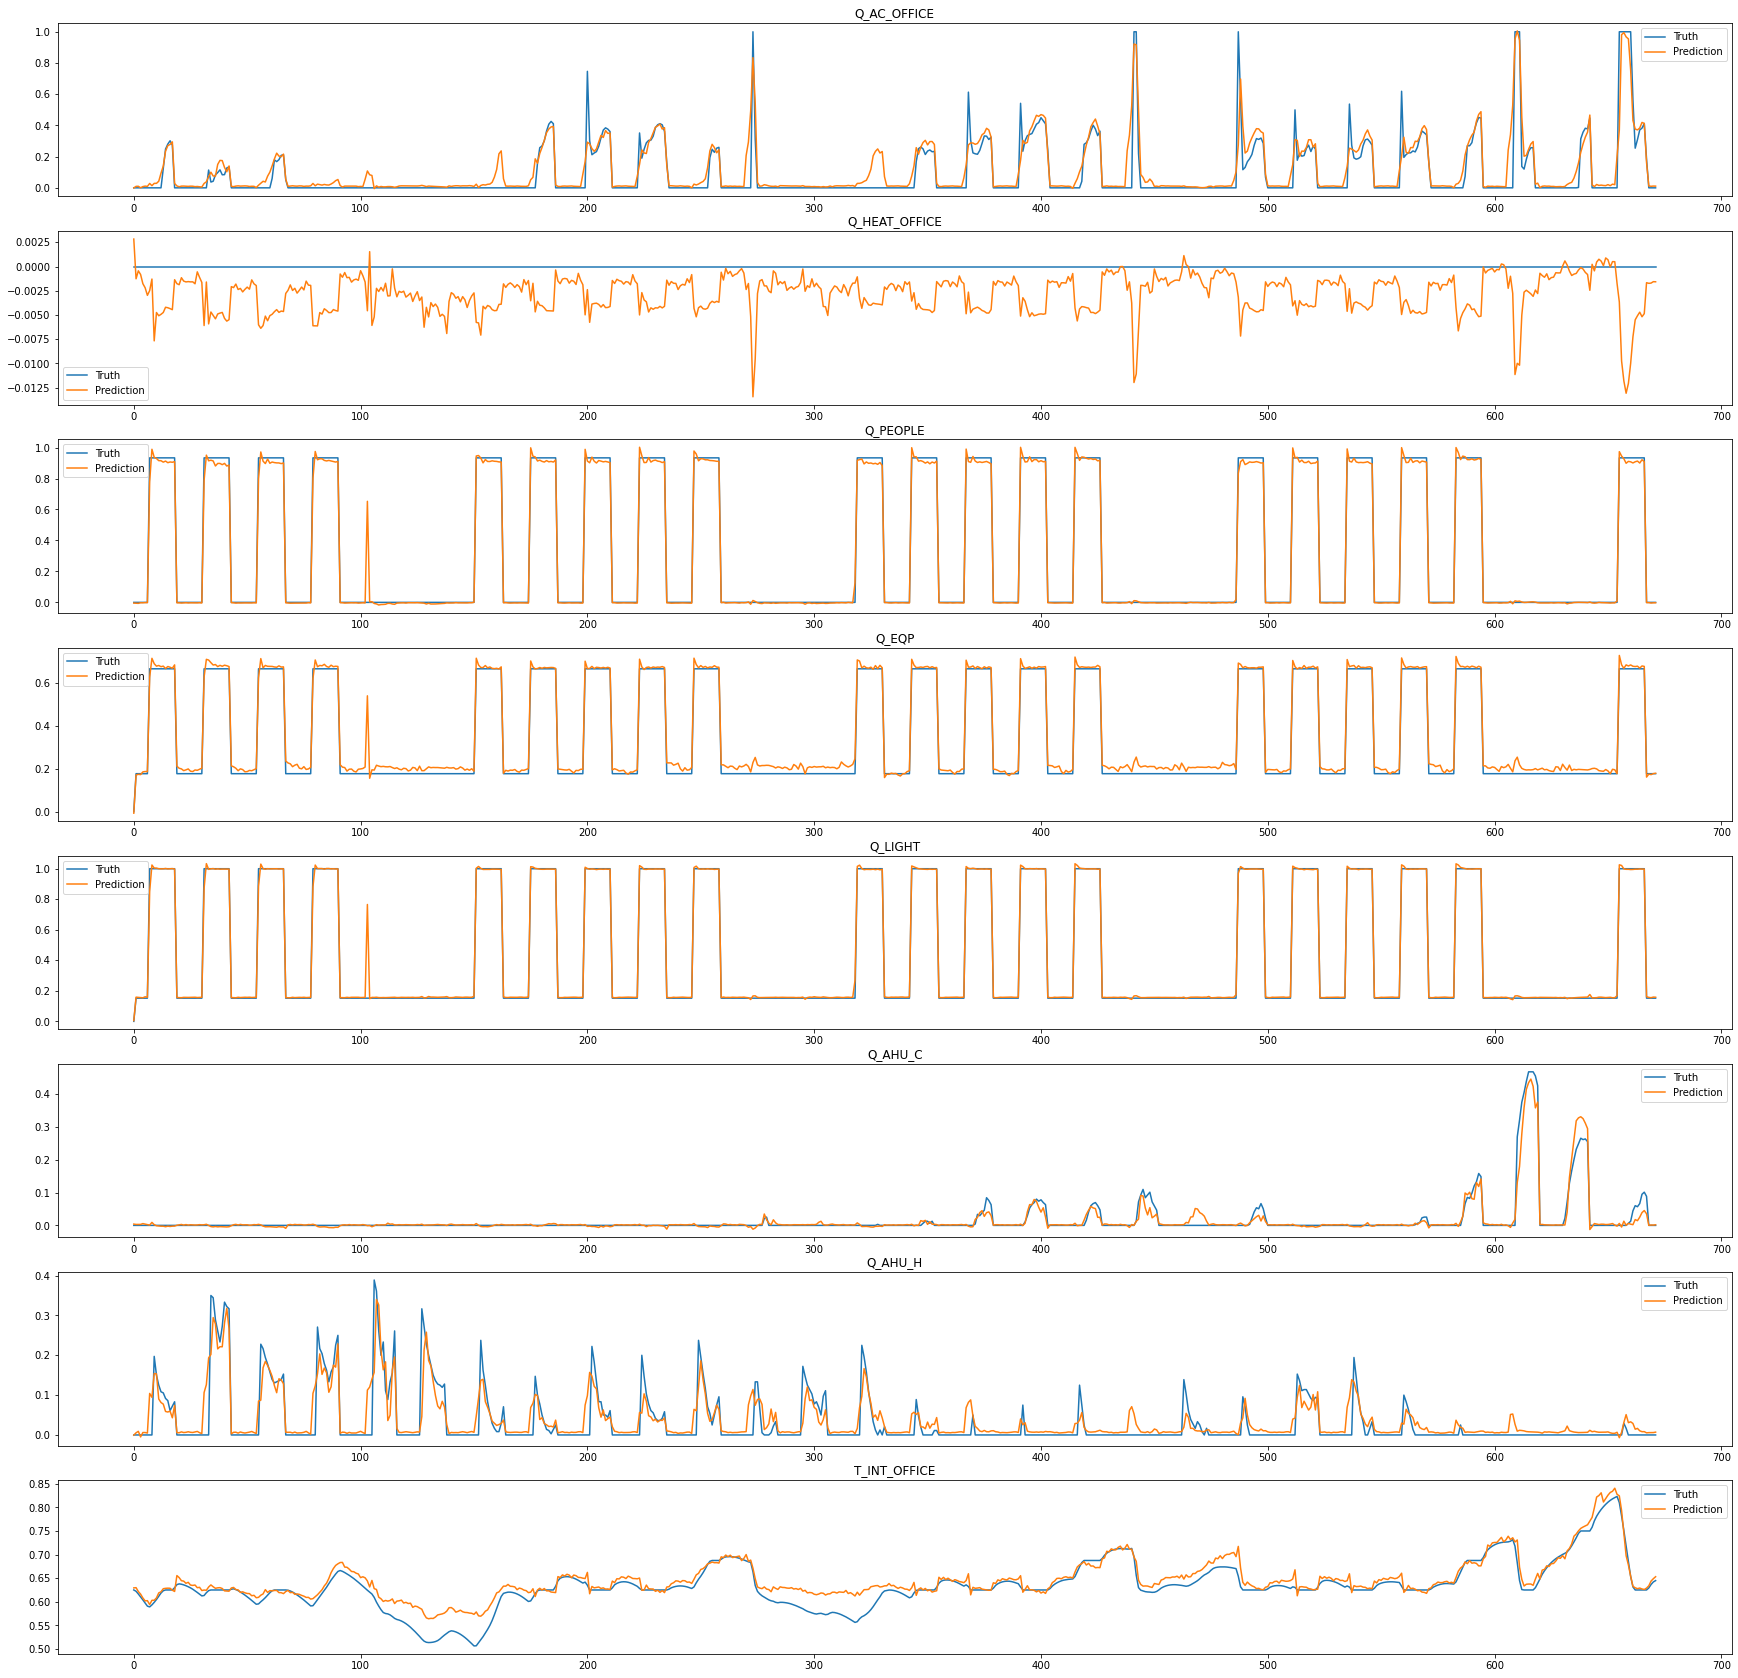

In [6]:
# Select training example
idx = np.random.randint(0, len(dataloader.dataset))
x, y = dataloader.dataset[idx]

# Run predictions
with torch.no_grad():
    x = torch.Tensor(x[np.newaxis, :, :])
    netout = net(x.to(device)).cpu().numpy()

plt.figure(figsize=(30, 30))
for idx_output_var in range(8):
    # Select real temperature
    y_true = y[:, idx_output_var]

    y_pred = netout[0, :, idx_output_var]

    plt.subplot(8, 1, idx_output_var+1)
    
    plt.plot(y_true, label="Truth")
    plt.plot(y_pred, label="Prediction")
    plt.title(dataloader.dataset.labels["X"][idx_output_var])
    plt.legend()
plt.savefig("fig")

# Evaluation

### Load evaluation dataset

In [10]:
dataset_eval = OzeEvaluationDataset(dataset_x_path="datasets/x_test_QK7dVsy.csv", labels_path="labels.json")
m_test = len(dataset_eval)

### Run prediction

In [11]:
predictions = np.zeros((m_test, K, 8))
with torch.no_grad():
    for idx, line in tqdm(enumerate(dataset_eval), total=m_test):
        # Run prediction
        netout = net(torch.Tensor(line[np.newaxis, :, :]).to(device)).cpu().numpy()
        
        # De-normalize output
        output = netout * (M - m + np.finfo(float).eps) + m
        predictions[idx] = output

100%|██████████| 500/500 [00:22<00:00, 22.17it/s]


### Export as csv

In [12]:
lines_output = predictions.reshape((m_test, -1))
csv_header = [f"{var_name}_{k}" for var_name in dataset_eval.labels['X'] for k in range(K)]

pd.DataFrame(lines_output, columns=csv_header).to_csv(f"y_bench.csv")